# Rough demo of how to get landmarks interactively from images

In [16]:
%matplotlib notebook

In [17]:
import ipywidgets
import glob
import numpy as np
import os
import pandas as pd
import pdb
import pickle

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
from skimage.io import imread_collection, imread

In [5]:
from utils.display.videofig import videofig, redraw_fn
from utils.log import logger

In [6]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
def showplus(img):
    fig, ax = plt.subplots()
    ax.imshow(img)
    return (fig,ax)

In [8]:
seq = imread_collection("/Users/lambert/images/virat2-aerial/09152008flight2tape1_10/frames/*.png", conserve_memory=True)
len(seq)

9291

# Draw the frames we'll click in

<IPython.core.display.Javascript object>


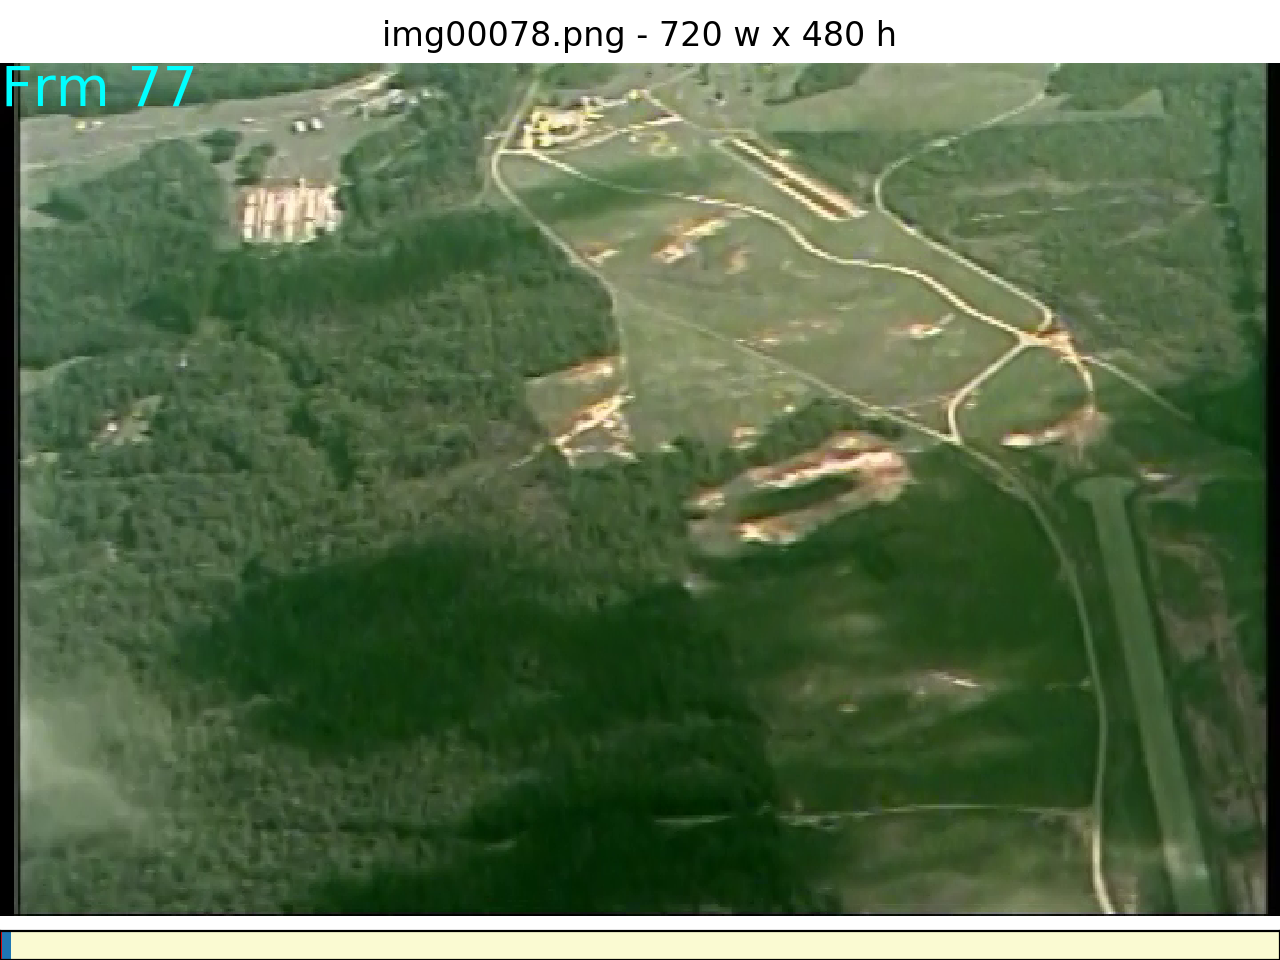

In [25]:
f = videofig(len(seq), redraw_fn, proc_func=lambda f: (seq[f], None, 
            "{0} - {1} w x {2} h".format(os.path.basename(seq._files[f]), seq[f].shape[1], seq[f].shape[0])),
         autostart=False, return_fig=True)

In [26]:
# Create an output space for displaying the results of an image click
outw = ipywidgets.Output(layout={'border': '2px solid black'})
outw
# You can clear this later with outw.clear_output()

Output(layout=Layout(border=u'2px solid black'))

In [19]:
outw.clear_output()

In [27]:
landmarkdf = pd.DataFrame(columns=["file", "landmark", "x", "y", "fullpath"])

In [28]:
# Set up our onclick handler.  Note that we can identify the coords and the image that is currently displayed.
def onclick(event, outw, fig, seq):
    global landmarkdf
    
    # Unfortunately this gets called even if the user just clicks on the Slider instead of the image.
    # You can tell this if ydata < 1.
    if event.ydata < 1:
        return
    strmsg1 = '{0} click: button={1}, x={2}, y={3}, xdata={4}, ydata={5}'.format(
        'double' if event.dblclick else 'single', event.button,
         event.x, event.y, event.xdata, event.ydata)
    # Figure out our slider position
    dex = int(f.vf_scroll_slider.val)
    filename = seq._files[dex]
    strmsg = '{0} xdata={1}, ydata={2}'.format(filename, event.xdata, event.ydata)
    # Add a row to our annotations
    landmarkdf = landmarkdf.append({'file': os.path.basename(filename), 'landmark':'arp-left', 
                       'x': event.xdata, 'y':event.ydata, 'fullpath': filename}, ignore_index=True)
    # Advance the frame
    f.vf_scroll_slider.set_val(f.vf_scroll_slider.val + 1)
    with outw:
        print(strmsg)

#Bind the onclick handler.  Note that this just adds another handler, it does not replace the last handler bound. 
# So we try to disconnect first
if 'cid' in globals() and cid:
   f.canvas.mpl_disconnect(cid) 
cid = f.canvas.mpl_connect('button_press_event', lambda event: onclick(event, outw, f, seq))

## At this point you can begin clicking in the videofig window above.  
As you do, the outw widget will display info, and the landmarkdf will get appended to.

In [15]:
f.canvas.mpl_disconnect(cid)

In [ ]:
# Hide axes if you want to save the image.
f.vf_scroll_axes.set_visible(False)

In [29]:
landmarkdf

,file,landmark,x,y,fullpath
0,img00001.png,arp-left,561.982422,223.271875,/Users/lambert/images/virat2-aerial/09152008fl...
1,img00077.png,arp-left,611.482422,425.771875,/Users/lambert/images/virat2-aerial/09152008fl...


In [ ]:
#Example of how to drop frames where you made a mistake
#landmarkdf = landmarkdf.drop([14])

In [ ]:
# Now save your labels
if False:   # Prevent this line from being executed accidentally.
with open("/Users/lambert/images/labels.pickle", "wb") as fd:
    pickle.dump(landmarkdf, fd)

In [11]:
with open("/Users/lambert/images/labels.pickle", "rb") as fd:
    landmarkdf = pickle.load(fd)

# Display boxes centered at your landmarks

In [22]:
def overlay_annots(axes, f, df):
    # Find the annotations associated with image f
    
    anns = df.loc[df.fullpath == seq._files[f]]
    
    for index, row in anns.iterrows():
        radius=40
        h = 2*radius + 1
        w = 2*radius + 1
        assert h > 0
        assert w > 0
        cx = round(row['x'])
        cy = round(row['y'])
        rect = mpl.patches.Rectangle((cx - radius, cy-radius), w, h, edgecolor='red', facecolor='none', linewidth=1)
        axes.add_patch(rect)
        #print("xmin {0}  xmax {1}  ymin {2} ymax {3}".format(row['xmin'], row['xmax'], row['ymin'], row['ymax']))
        rx, ry = rect.get_xy()
        a = axes.annotate(row['landmark'], (rx-2, ry-2), color='red', weight='bold', fontsize=10, ha='left', va='bottom')

<IPython.core.display.Javascript object>


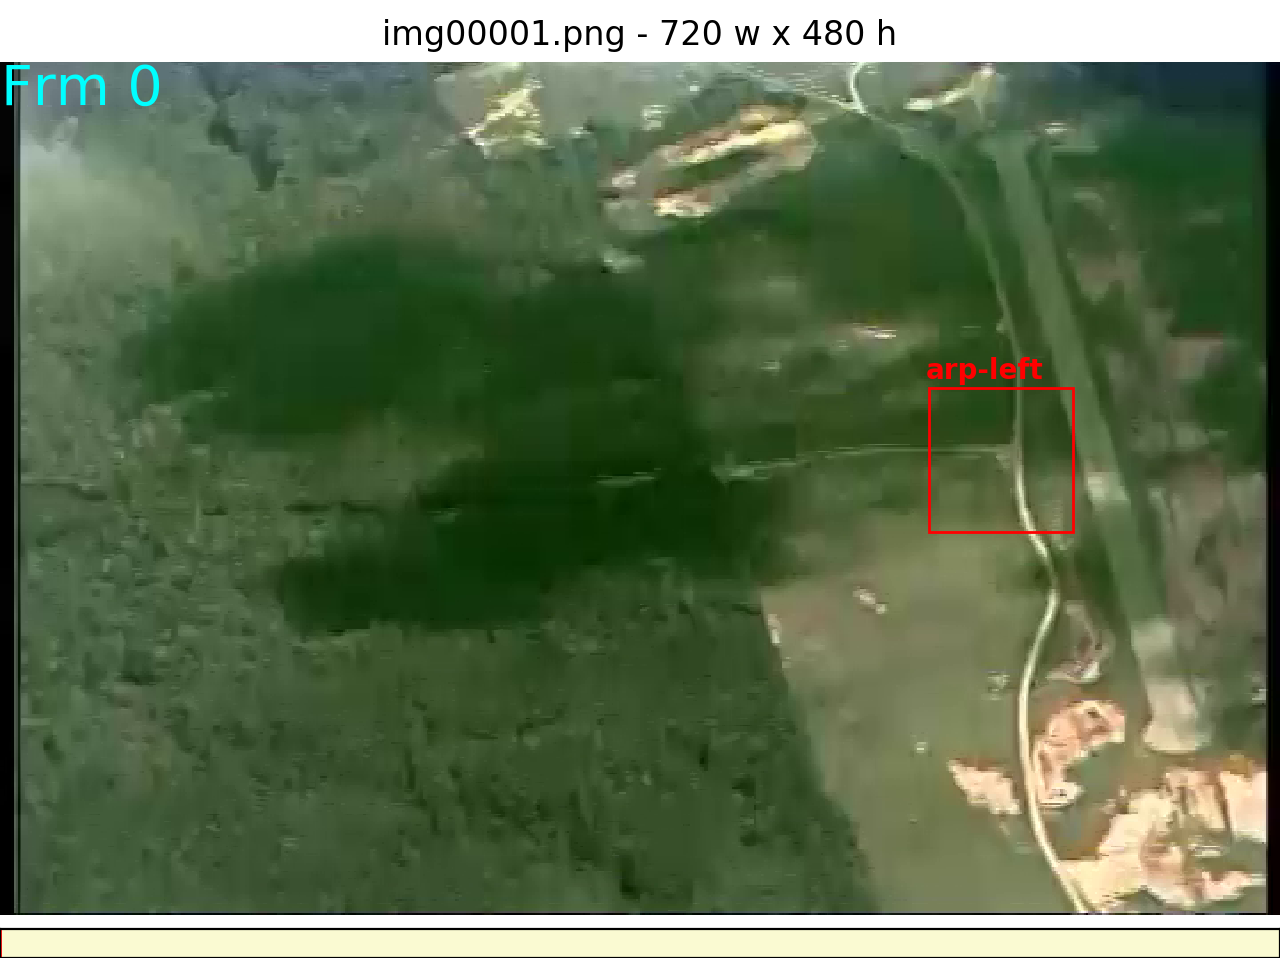

In [30]:
f2 = videofig(len(seq), redraw_fn, proc_func=lambda f: (seq[f], None, 
            "{0} - {1} w x {2} h".format(os.path.basename(seq._files[f]), seq[f].shape[1], seq[f].shape[0])),
             overlay_func = lambda ax, f: (overlay_annots(ax, f, landmarkdf)),
         autostart=False, return_fig=True)